## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [17]:
df=pd.read_csv('ab_data.csv')
df.head()     

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]   #no. of rows

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
prop_user_converted=df[df['converted']==1].user_id.nunique()/df.shape[0]
prop_user_converted

0.1194418598333322

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### No missing data

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
i=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index 
df2=df.drop(i)

In [9]:
# Double Check all of the incorrect rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2.user_id[df2.user_id.duplicated()].index   #will give the number of duplicated row

Int64Index([2893], dtype='int64')

c. What is the row information for the repeat **user_id**? 

In [18]:
df2.loc[2893]   #the information of row 2893 

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2=df2.drop_duplicates()

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [95]:
convert_prop=df2['converted'].mean()
convert_prop

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [73]:
df2.query("group=='control'")["converted"].mean()  #converted=1, non_converted=0 by avereging those how converted from the control group

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [74]:
df2.query("group=='treatment'")["converted"].mean()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [77]:
df2.query("landing_page=='new_page'").shape[0]/df2.shape[0]

0.5000636646764286

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Both groups have similar convertion propabilities of 0.12 and 0.119 for indivisual from control group and treatment group respectivlly. no sufficient evidence may be this experement needs a longer perioud of time to measure if the new page is usfull or not. **

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Ho:**$p_{old}$** >= **$p_{new}$**

H1: **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [40]:
p_new=df2['converted'].mean() #since the two pages have equal conversion rate 
p_new

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [41]:
p_old=df2['converted'].mean()    #assume they are equal to the converted rate in ab_data.csv regardless of the page 
p_old

0.11959667567149027

In [42]:
#difference in conversion rate of both pages 
diff=p_old-p_new
diff

0.0

c. What is $n_{new}$?

In [43]:
#calculate the no of useres with new pages 
n_new=df2[df['landing_page']=='new_page'].count()[0]
n_new

/Users/mamaal3sl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


145311

d. What is $n_{old}$?

In [44]:
#calculate the no of useres with old pages 
n_old=df2[df['landing_page']=='old_page'].count()[0]
n_old

/Users/mamaal3sl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [52]:
#using binomial distribution 
new_page_converted=np.random.binomial(1, p_new, size= n_new )
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [53]:
old_page_converted=np.random.binomial(1, p_old, size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [54]:
obs_diff=new_page_converted.mean()-old_page_converted.mean()
obs_diff

-0.0015242266155476442

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [36]:
p_diffs=[]
for i in range(10000):
    new_page_converted_ittr=np.random.binomial(1, p_new, size= n_new )
    old_page_converted_ittr=np.random.binomial(1, p_old, size=n_old)
    p_diffs.append(new_page_converted_ittr.mean()-old_page_converted_ittr.mean())
    p_diffs

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

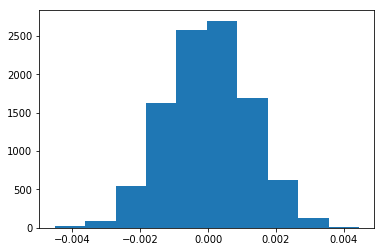

In [37]:
plt.hist(p_diffs);

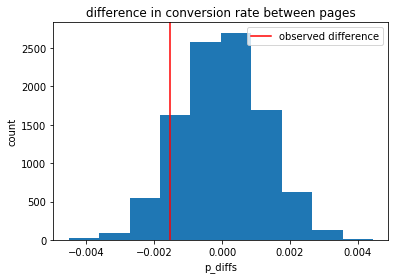

In [55]:
plt.hist(p_diffs);
plt.title('difference in conversion rate between pages');
plt.axvline(obs_diff, color='r', label='observed difference');
plt.legend();
plt.xlabel('p_diffs');
plt.ylabel('count');      

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [56]:
(obs_diff<p_diffs).mean() 

0.89600000000000002

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**we want to see if the observed difference falls in to the range of the null value .**
**in part j, p-value was calculated. with error I of 5% we can say that we failed to reject the null hypothesis **
Ho:**$p_{old}$** >= **$p_{new}$** since our p-value = 0.896

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [57]:
import statsmodels.api as sm

convert_old = df2['converted'].mean()
convert_new = df2['converted'].mean()
n_old = df2[df['landing_page']=='old_page'].count()[0]
n_new = df2[df['landing_page']=='new_page'].count()[0]

/Users/mamaal3sl/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/mamaal3sl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/mamaal3sl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [62]:
z_score, p_value =sm.stats.proportions_ztest(count=[convert_old, convert_new], nobs=[n_old, n_new], alternative='larger')

z_score, p_value

(6.2273498652281703e-05, 0.49997515646845514)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

** 
yes the finding do agree with part k & j, the p-value is different than the one computed in j but still insignificance (more than 0.05) meaning that we failed to reject the null hypothsis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

In [64]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [65]:
df2['intercept']=1
df2[['old_page', 'new_page']]=pd.get_dummies(df2['landing_page'])
df2[['control','ab_page']]=pd.get_dummies(df2['group'])
df2.head(2)


,user_id,timestamp,group,landing_page,converted,intercept,old_page,new_page,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0


In [66]:
df2=df2.drop('control', axis=1)
df2.tail(2)

,user_id,timestamp,group,landing_page,converted,intercept,old_page,new_page,ab_page
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,1,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [67]:
import statsmodels.api as sm
lgr=sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results= lgr.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [68]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-22 15:32 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

** p value for the ab_page is 0.1897 not significant so we failed to reject the null hypothsis. 
 The null and alternative hypothesis for the logistic regression is:** 
 
 
**H0: new_page = old _page       H1: new_page != old _page**

while in part II is: 
Ho:**$p_{old}$** >= **$p_{new}$**     H1: **$p_{old}$** < **$p_{new}$**

**in ab testing we are just comparing the new version with the old one with out considereng other options or other factors 
also, it is affcted by factors like Change Aversion and Novelty Effect ecpecaly that we have old uses involved in the experement.**  

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

** It is definatly usefull to test more factors which can add valuable improvment to the model.but we need to keep in mind testing the relationship between the factors and the predictor together and indivisually to observe the negative confounder. wheres some of the variable reduce the assocaiation between the additional factor and the outcome i.e convert or not, which is the reason of having a significant relationship with a factor and after adding additional factors it becomes not significant(1) **
**in addition, adding more variables can make the model worse by overfitting the model. so its very important to make sure that the model fit the data well using the r squered value or (coefficient of determination)(2).**
(1)https://www.researchgate.net/post/Why_in_regression_analysis_the_inclusion_of_a_new_variable_makes_other_variables_that_previously_were_not_statistically_significant2
(2)https://towardsdatascience.com/understanding-multiple-regression-249b16bde83e

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,new_page,treatment,control,ab_page
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,1,0,1


In [49]:
df_new['country'].unique()

array(['US', 'UK', 'CA'], dtype=object)

In [51]:
### Create the necessary dummy variables
df_new[['US','UK','CA']]=pd.get_dummies(df_new['country'])

In [61]:
#Logestic regression using country variables as explantory variables 
lgr3=sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK']])
results3= lgr3.fit()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


In [62]:
results3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-14 11:52 AIC:              212781.0880
No. Observations:   290585           BIC:              212812.8269
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3154  0.0000  -2.0101  -1.9833
US           -0.0408    0.0269    -1.5176  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7462  0.4555  -0.0161   0.0360
==================================================================

"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:
#3rd Logestic regression using country and ab_page variables as explantory variables 
lgr2=sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results2= lgr2.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [54]:
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-14 11:16 AIC:              212781.3782
No. Observations:   290585           BIC:              212823.6968
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7629  0.0000  -2.0067  -1.9718
ab_page      -0.0150    0.0114    -1.3076  0.1910  -0.0374   0.0075
US           -0.0408    0.0269    -1.5159  0.1296  -0.0934   0.0119
UK            0.0099    0.0133     0.7437  0.4570  -0.0162   0.0359
==================================================================

"""

<a id='conclusions'></a>
## Conclusions
both AB testing and regression models failed to reject the null hypothesis that the old page is no better then the new web page. in regression models, multible explantory variables were tested indivesually and together. type of customer  (control or treatment) and customer country (UK, US,CA). neither of these variables had a significant effect on predicting converting to new page or not. running this experiment can have a clearer conclusion to this study. 



## Resources:

(1)https://www.researchgate.net/post/Why_in_regression_analysis_the_inclusion_of_a_new_variable_makes_other_variables_that_previously_were_not_statistically_significant2
(2)Understanding Multiple Regression https://towardsdatascience.com/understanding-multiple-regression-249b16bde83e
(3)For stats.proportions_ztest, this webpage was very usefull
https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/





### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.